In [4]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# ===========================================================
# 📁 Dataset path (Kaggle auto-download)
# ===========================================================
DATASET_PATH = "/kaggle/input/berlin-database-of-emotional-speech-emodb/wav"

# ===========================================================
# 🎵 Helper function for feature extraction
# ===========================================================
def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        # Data augmentation (safe versions)
        y_stretch = librosa.effects.time_stretch(y=y, rate=0.8)
        y_shift = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=2)

        # Extract MFCC features
        mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
        mfcc_stretch = np.mean(librosa.feature.mfcc(y=y_stretch, sr=sr, n_mfcc=40).T, axis=0)
        mfcc_shift = np.mean(librosa.feature.mfcc(y=y_shift, sr=sr, n_mfcc=40).T, axis=0)

        # Concatenate features
        combined = np.hstack([mfcc, mfcc_stretch, mfcc_shift])
        return combined
    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {e}")
        return None

# ===========================================================
# 📦 Load dataset and extract features
# ===========================================================
files, labels = [], []
emotion_map = {
    'W': 'anger',
    'L': 'boredom',
    'E': 'disgust',
    'A': 'fear',
    'F': 'happiness',
    'T': 'sadness',
    'N': 'neutral'
}

for file in os.listdir(DATASET_PATH):
    if file.endswith(".wav"):
        emotion = emotion_map.get(file[5], None)
        if emotion:
            features = extract_features(os.path.join(DATASET_PATH, file))
            if features is not None:
                files.append(features)
                labels.append(emotion)

X = np.array(files)
y = np.array(labels)

print("✅ Feature extraction complete.")
print("Samples extracted:", len(X))
print(pd.Series(y).value_counts())

# ===========================================================
# 🧠 Prepare data
# ===========================================================
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

# Expand dimensions for Conv1D (samples, timesteps, features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print("✅ Data ready for training.")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
print("Classes:", le.classes_)

# ===========================================================
# 🧩 CNN Model
# ===========================================================
num_classes = len(np.unique(y_encoded))

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# ===========================================================
# ⚙️ Compile and Train
# ===========================================================
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# ===========================================================
# 📈 Evaluate
# ===========================================================
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


✅ Feature extraction complete.
Samples extracted: 535
anger        127
boredom       81
neutral       79
happiness     71
fear          69
sadness       62
disgust       46
Name: count, dtype: int64
✅ Data ready for training.
Train shape: (428, 120, 1)
Test shape: (107, 120, 1)
Classes: ['anger' 'boredom' 'disgust' 'fear' 'happiness' 'neutral' 'sadness']
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.2031 - loss: 3.8278 - val_accuracy: 0.3364 - val_loss: 2.0653
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3047 - loss: 1.8307 - val_accuracy: 0.3271 - val_loss: 1.6734
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3786 - loss: 1.5917 - val_accuracy: 0.3551 - val_loss: 1.5962
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3808 - loss: 1.5543 - val_accuracy: 0.5047 - val_loss: 1.3310
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4318 - loss: 1.4449 - val_accuracy: 0.4486 - val_loss: 1.3851
Epoch 6/

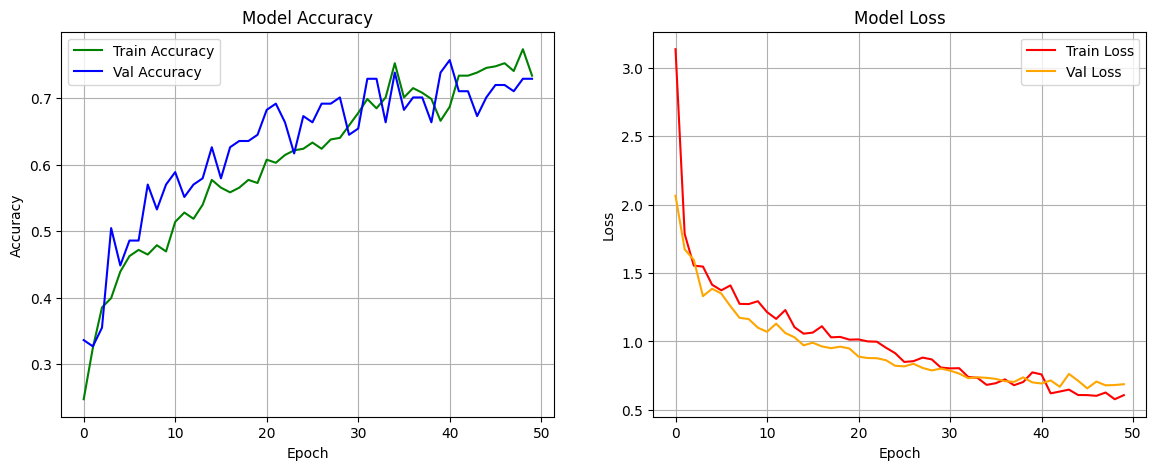

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step


<Figure size 800x600 with 0 Axes>

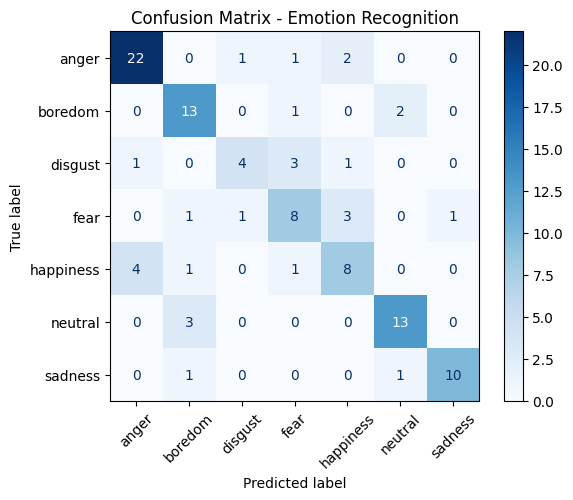

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ===========================================================
# 📈 1. Plot Training vs Validation Accuracy & Loss
# ===========================================================
plt.figure(figsize=(14,5))

# 🔹 Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='blue')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 🔹 Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# ===========================================================
# 🔹 2. Confusion Matrix
# ===========================================================
# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(8,6))
disp.plot(cmap='Blues', xticks_rotation=45, colorbar=True)
plt.title("Confusion Matrix - Emotion Recognition")
plt.show()
